<a href="https://colab.research.google.com/github/dimitarpg13/semsimula/blob/main/notebooks/game_addition/q_learning_agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Addition Game: Adversarial Reinforcement Learning

## Game Definition (from Blackwell's "Game Theory and Statistical Decisions")

> *The parameters of the game k and N are given. Player I and Player II alternately choose integers, each choice being one of the integers 1,...,k and each choice made with the knowledge of all preceding choices. As soon as the sum of the chosen integers exceeds N, the last player to choose loses the game and pays his opponent one unit.*

This is a perfect information, zero-sum, sequential game. We'll implement Q-learning agents that learn to play optimally through self-play.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from dataclasses import dataclass
from typing import Tuple, List, Optional
import random
from tqdm import tqdm

# Set style for visualizations
plt.style.use('dark_background')
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.facecolor'] = '#1a1a2e'
plt.rcParams['figure.facecolor'] = '#0f0f23'
plt.rcParams['axes.edgecolor'] = '#4a4a6a'
plt.rcParams['axes.labelcolor'] = '#e0e0e0'
plt.rcParams['xtick.color'] = '#a0a0a0'
plt.rcParams['ytick.color'] = '#a0a0a0'
plt.rcParams['text.color'] = '#e0e0e0'
plt.rcParams['grid.color'] = '#2a2a4a'
plt.rcParams['grid.alpha'] = 0.5


## 1. Game Environment

The state of the game is fully characterized by:
- The current sum of all chosen integers
- Whose turn it is (Player 1 or Player 2)

The game ends when the sum exceeds N.


In [5]:
@dataclass
class GameState:
    """Represents the current state of the Addition game."""
    current_sum: int
    current_player: int  # 0 for Player I, 1 for Player II

    def __hash__(self):
        return hash((self.current_sum, self.current_player))

    def __eq__(self, other):
        return (self.current_sum == other.current_sum and
                self.current_player == other.current_player)


class AdditionGame:
    """The Addition game environment.

    Parameters:
        k: Maximum integer that can be chosen (choices are 1, 2, ..., k)
        N: Threshold - the game ends when sum exceeds N
    """

    def __init__(self, k: int, N: int):
        self.k = k
        self.N = N
        self.reset()

    def reset(self) -> GameState:
        """Reset the game to initial state."""
        self.state = GameState(current_sum=0, current_player=0)
        self.history: List[int] = []
        self.done = False
        self.winner = None
        return self.state

    def get_valid_actions(self) -> List[int]:
        """Returns list of valid actions (1 to k)."""
        return list(range(1, self.k + 1))

    def step(self, action: int) -> Tuple[GameState, float, float, bool]:
        """Execute an action and return (new_state, reward_p1, reward_p2, done).

        Returns:
            new_state: The resulting game state
            reward_p1: Reward for Player I (+1 win, -1 loss, 0 ongoing)
            reward_p2: Reward for Player II (+1 win, -1 loss, 0 ongoing)
            done: Whether the game has ended
        """
        if self.done:
            raise ValueError("Game is already over!")

        if action < 1 or action > self.k:
            raise ValueError(f"Invalid action {action}. Must be in [1, {self.k}]")

        # Record action
        self.history.append(action)
        current_player = self.state.current_player

        # Update sum
        new_sum = self.state.current_sum + action

        # Check if game ends
        if new_sum > self.N:
            self.done = True
            # Current player loses (they made sum exceed N)
            self.winner = 1 - current_player
            reward_p1 = 1.0 if self.winner == 0 else -1.0
            reward_p2 = -reward_p1
        else:
            reward_p1 = 0.0
            reward_p2 = 0.0

        # Update state
        self.state = GameState(
            current_sum=new_sum,
            current_player=1 - current_player  # Switch player
        )

        return self.state, reward_p1, reward_p2, self.done

    def render(self):
        """Print the current game state."""
        print(f"Sum: {self.state.current_sum} / N={self.N}")
        print(f"History: {self.history}")
        print(f"Current player: {'I' if self.state.current_player == 0 else 'II'}")
        if self.done:
            print(f"Winner: Player {'I' if self.winner == 0 else 'II'}")


## 2. Q-Learning Agent

We'll use tabular Q-learning since the state space is finite and manageable. Each agent maintains a Q-table mapping (state, action) pairs to expected returns.


In [6]:
class QLearningAgent:
    """Q-learning agent for the Addition game.

    Uses ε-greedy exploration with decaying ε.
    """

    def __init__(
        self,
        player_id: int,
        k: int,
        learning_rate: float = 0.1,
        discount_factor: float = 0.99,
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.01,
        epsilon_decay: float = 0.9995
    ):
        self.player_id = player_id
        self.k = k
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

        # Q-table: maps (sum, action) -> Q-value
        # We only need to store states where it's this agent's turn
        self.q_table = defaultdict(lambda: defaultdict(float))

        # Statistics
        self.wins = 0
        self.losses = 0
        self.games = 0

    def get_state_key(self, state: GameState) -> int:
        """Convert state to key for Q-table lookup."""
        return state.current_sum

    def select_action(self, state: GameState, valid_actions: List[int], training: bool = True) -> int:
        """Select action using ε-greedy policy."""
        if training and random.random() < self.epsilon:
            return random.choice(valid_actions)

        state_key = self.get_state_key(state)
        q_values = self.q_table[state_key]

        # Find action with highest Q-value
        best_action = None
        best_value = float('-inf')

        for action in valid_actions:
            value = q_values[action]
            if value > best_value:
                best_value = value
                best_action = action

        # If all Q-values are 0 (unvisited), choose randomly
        if best_action is None or best_value == 0:
            return random.choice(valid_actions)

        return best_action

    def update(self, state: GameState, action: int, reward: float,
               next_state: Optional[GameState], done: bool, next_valid_actions: List[int]):
        """Update Q-value using the Q-learning update rule."""
        state_key = self.get_state_key(state)
        current_q = self.q_table[state_key][action]

        if done:
            # Terminal state: no future rewards
            target = reward
        else:
            # For the Addition game, the next state where this agent acts
            # is after the opponent moves. We need to account for this.
            # Here, we use the immediate reward + discounted future.
            # Since it's a two-player game, we'll handle this in the training loop.
            next_state_key = self.get_state_key(next_state)
            next_q_values = self.q_table[next_state_key]
            max_next_q = max([next_q_values[a] for a in next_valid_actions], default=0)
            target = reward + self.gamma * max_next_q

        # Q-learning update
        self.q_table[state_key][action] = current_q + self.lr * (target - current_q)

    def decay_epsilon(self):
        """Decay exploration rate."""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

    def record_result(self, won: bool):
        """Record game result."""
        self.games += 1
        if won:
            self.wins += 1
        else:
            self.losses += 1

    def win_rate(self) -> float:
        """Calculate win rate."""
        return self.wins / max(1, self.games)


## 3. Training Loop

We train both agents through self-play. Each episode is a full game, and both agents learn from the outcomes.


In [7]:
def train_agents(
    game: AdditionGame,
    agent1: QLearningAgent,
    agent2: QLearningAgent,
    num_episodes: int = 50000,
    log_interval: int = 1000
) -> dict:
    """Train two agents through self-play.

    Returns:
        Dictionary containing training statistics
    """
    agents = [agent1, agent2]
    stats = {
        'episodes': [],
        'agent1_win_rate': [],
        'agent2_win_rate': [],
        'epsilon': [],
        'avg_game_length': []
    }

    game_lengths = []

    for episode in tqdm(range(num_episodes), desc="Training"):
        state = game.reset()

        # Store transitions for each agent
        transitions = [[], []]  # [agent1_transitions, agent2_transitions]

        while not game.done:
            current_player = state.current_player
            agent = agents[current_player]

            valid_actions = game.get_valid_actions()
            action = agent.select_action(state, valid_actions)

            # Store state and action for later update
            transitions[current_player].append({
                'state': state,
                'action': action
            })

            next_state, reward_p1, reward_p2, done = game.step(action)
            state = next_state

        # Game ended - assign terminal rewards
        rewards = [reward_p1, reward_p2]
        game_lengths.append(len(game.history))

        # Update Q-values for each agent using backward updates
        for player_id in [0, 1]:
            agent = agents[player_id]
            player_transitions = transitions[player_id]
            reward = rewards[player_id]

            # Update from last state backward
            for i in reversed(range(len(player_transitions))):
                trans = player_transitions[i]

                if i == len(player_transitions) - 1:
                    # Last action by this agent
                    agent.update(
                        trans['state'],
                        trans['action'],
                        reward,
                        None,
                        True,
                        game.get_valid_actions()
                    )
                else:
                    # Intermediate action - next state is the next time this agent acts
                    next_trans = player_transitions[i + 1]
                    agent.update(
                        trans['state'],
                        trans['action'],
                        0,  # No intermediate reward
                        next_trans['state'],
                        False,
                        game.get_valid_actions()
                    )

            # Record result
            agent.record_result(game.winner == player_id)

        # Decay epsilon for both agents
        agent1.decay_epsilon()
        agent2.decay_epsilon()

        # Log statistics
        if (episode + 1) % log_interval == 0:
            stats['episodes'].append(episode + 1)
            stats['agent1_win_rate'].append(agent1.wins / max(1, agent1.games) * 100)
            stats['agent2_win_rate'].append(agent2.wins / max(1, agent2.games) * 100)
            stats['epsilon'].append(agent1.epsilon)
            stats['avg_game_length'].append(np.mean(game_lengths[-log_interval:]))

            # Reset counters for windowed stats
            agent1.wins = agent1.losses = agent1.games = 0
            agent2.wins = agent2.losses = agent2.games = 0

    return stats


## 4. Training the Agents

Let's train two Q-learning agents on the Addition game with parameters `k=3` and `N=10`.


In [8]:
# Game parameters
K = 3  # Can choose 1, 2, or 3
N = 10  # Game ends when sum exceeds 10

# Create game and agents
game = AdditionGame(k=K, N=N)

agent1 = QLearningAgent(
    player_id=0,
    k=K,
    learning_rate=0.2,
    discount_factor=0.95,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.9998
)

agent2 = QLearningAgent(
    player_id=1,
    k=K,
    learning_rate=0.2,
    discount_factor=0.95,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.9998
)

print(f"Training agents on Addition game with k={K}, N={N}")
print(f"Player I starts, choices are integers from 1 to {K}")
print(f"First player to make sum exceed {N} loses")


Training agents on Addition game with k=3, N=10
Player I starts, choices are integers from 1 to 3
First player to make sum exceed 10 loses


In [9]:
# Train the agents
stats = train_agents(game, agent1, agent2, num_episodes=50000, log_interval=500)


Training: 100%|██████████| 50000/50000 [00:01<00:00, 33327.43it/s]


## 5. Visualizing Training Progress


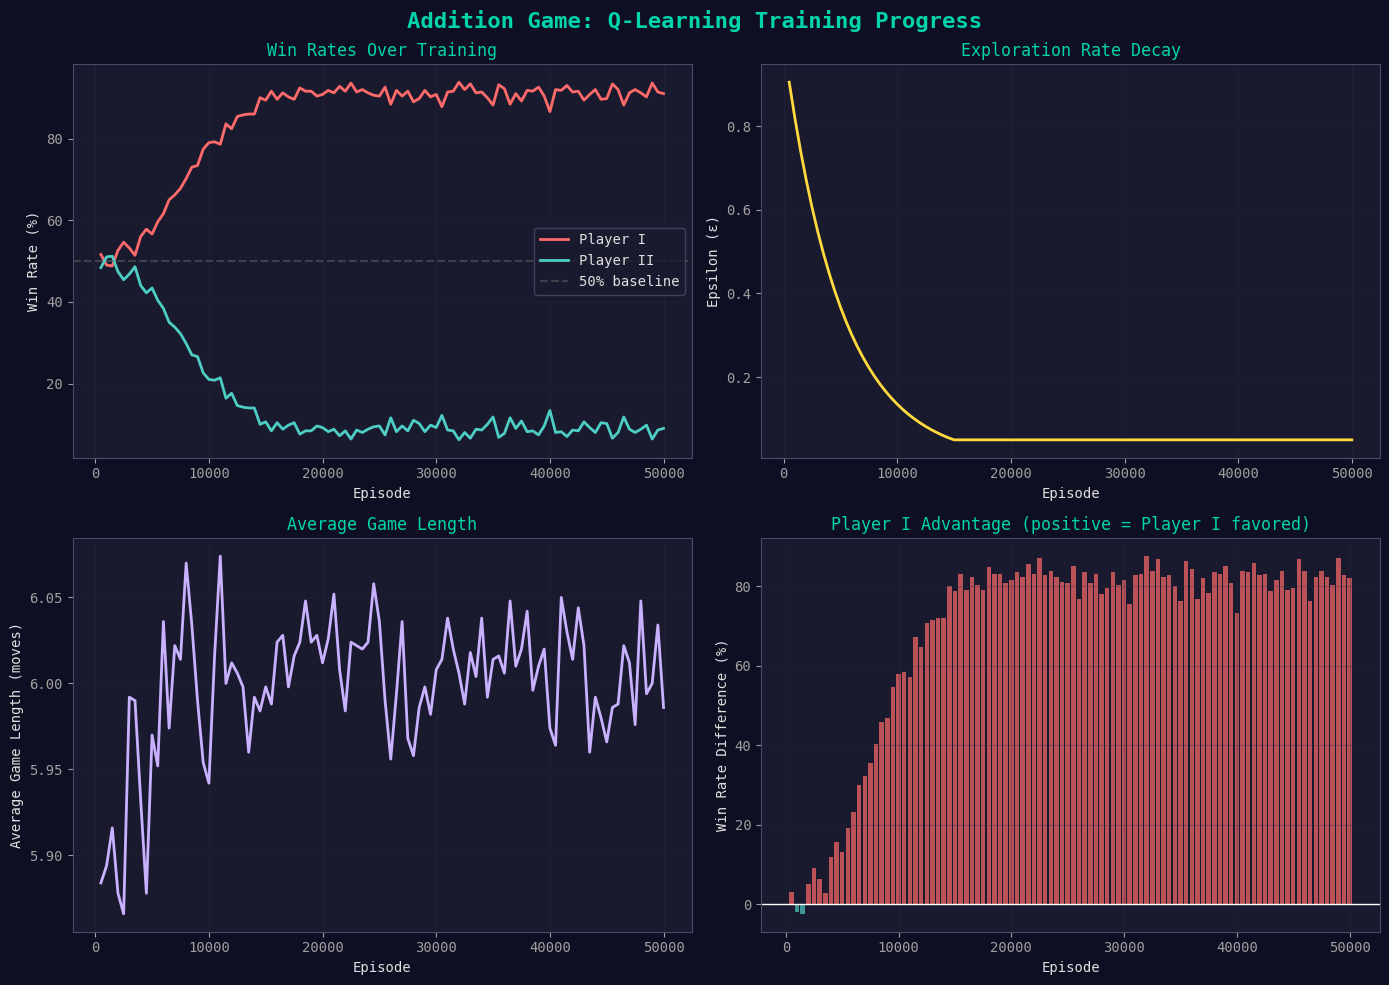

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Addition Game: Q-Learning Training Progress', fontsize=16, fontweight='bold', color='#00d4aa')

# Win rates
ax1 = axes[0, 0]
ax1.plot(stats['episodes'], stats['agent1_win_rate'], color='#ff6b6b', linewidth=2, label='Player I')
ax1.plot(stats['episodes'], stats['agent2_win_rate'], color='#4ecdc4', linewidth=2, label='Player II')
ax1.axhline(y=50, color='#666', linestyle='--', alpha=0.5, label='50% baseline')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Win Rate (%)')
ax1.set_title('Win Rates Over Training', color='#00d4aa')
ax1.legend(facecolor='#1a1a2e', edgecolor='#4a4a6a')
ax1.grid(True, alpha=0.3)

# Epsilon decay
ax2 = axes[0, 1]
ax2.plot(stats['episodes'], stats['epsilon'], color='#ffd93d', linewidth=2)
ax2.set_xlabel('Episode')
ax2.set_ylabel('Epsilon (ε)')
ax2.set_title('Exploration Rate Decay', color='#00d4aa')
ax2.grid(True, alpha=0.3)

# Average game length
ax3 = axes[1, 0]
ax3.plot(stats['episodes'], stats['avg_game_length'], color='#c9b1ff', linewidth=2)
ax3.set_xlabel('Episode')
ax3.set_ylabel('Average Game Length (moves)')
ax3.set_title('Average Game Length', color='#00d4aa')
ax3.grid(True, alpha=0.3)

# Win rate difference (advantage)
ax4 = axes[1, 1]
advantage = [a1 - a2 for a1, a2 in zip(stats['agent1_win_rate'], stats['agent2_win_rate'])]
colors = ['#ff6b6b' if a > 0 else '#4ecdc4' for a in advantage]
ax4.bar(stats['episodes'], advantage, color=colors, alpha=0.7, width=400)
ax4.axhline(y=0, color='#fff', linewidth=1)
ax4.set_xlabel('Episode')
ax4.set_ylabel('Win Rate Difference (%)')
ax4.set_title('Player I Advantage (positive = Player I favored)', color='#00d4aa')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Analyzing Learned Strategies

Let's examine the Q-values learned by each agent to understand their strategies.


Player I Strategy (moves first):


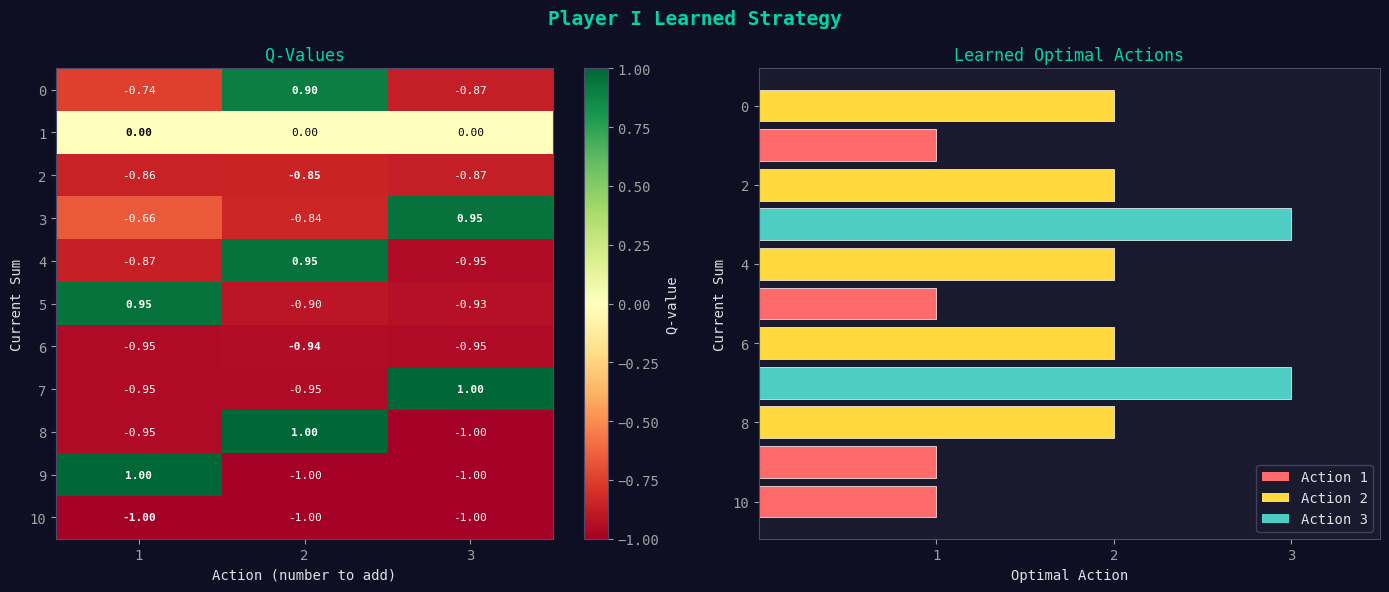


Player II Strategy:


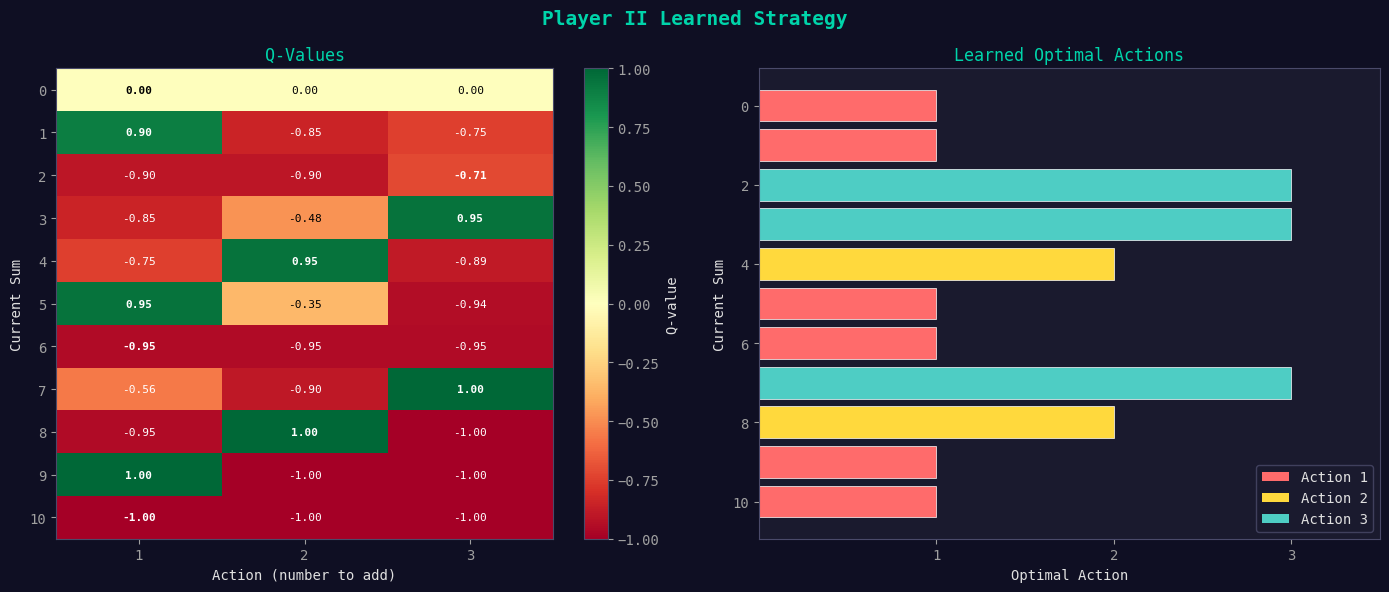

In [11]:
def visualize_policy(agent: QLearningAgent, k: int, N: int, player_name: str):
    """Visualize the learned policy as a heatmap of preferred actions."""

    # For each possible sum (state), find the preferred action
    sums = list(range(0, N + 1))
    actions = list(range(1, k + 1))

    # Create Q-value matrix
    q_matrix = np.zeros((len(sums), len(actions)))

    for i, s in enumerate(sums):
        q_values = agent.q_table[s]
        for j, a in enumerate(actions):
            q_matrix[i, j] = q_values[a]

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'{player_name} Learned Strategy', fontsize=14, fontweight='bold', color='#00d4aa')

    # Q-value heatmap
    im1 = ax1.imshow(q_matrix, aspect='auto', cmap='RdYlGn', vmin=-1, vmax=1)
    ax1.set_yticks(range(len(sums)))
    ax1.set_yticklabels(sums)
    ax1.set_xticks(range(len(actions)))
    ax1.set_xticklabels(actions)
    ax1.set_ylabel('Current Sum')
    ax1.set_xlabel('Action (number to add)')
    ax1.set_title('Q-Values', color='#00d4aa')
    plt.colorbar(im1, ax=ax1, label='Q-value')

    # Add best action annotations
    for i, s in enumerate(sums):
        best_action = np.argmax(q_matrix[i]) + 1
        for j, a in enumerate(actions):
            color = 'white' if abs(q_matrix[i, j]) > 0.5 else 'black'
            weight = 'bold' if a == best_action else 'normal'
            ax1.text(j, i, f'{q_matrix[i, j]:.2f}', ha='center', va='center',
                     color=color, fontsize=8, fontweight=weight)

    # Best action visualization
    best_actions = np.argmax(q_matrix, axis=1) + 1
    colors = ['#ff6b6b', '#ffd93d', '#4ecdc4']

    bars = ax2.barh(sums, best_actions, color=[colors[a-1] for a in best_actions], edgecolor='white', linewidth=0.5)
    ax2.set_xlabel('Optimal Action')
    ax2.set_ylabel('Current Sum')
    ax2.set_title('Learned Optimal Actions', color='#00d4aa')
    ax2.set_xticks([1, 2, 3])
    ax2.set_xlim(0, k + 0.5)
    ax2.invert_yaxis()

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors[i], label=f'Action {i+1}') for i in range(k)]
    ax2.legend(handles=legend_elements, loc='lower right', facecolor='#1a1a2e', edgecolor='#4a4a6a')

    plt.tight_layout()
    plt.show()

    return best_actions

print("Player I Strategy (moves first):")
p1_policy = visualize_policy(agent1, K, N, "Player I")

print("\nPlayer II Strategy:")
p2_policy = visualize_policy(agent2, K, N, "Player II")


## 7. Theoretical Optimal Strategy

For the Addition game with parameters `k` and `N`, the optimal strategy is known:

- **Losing positions** (for the player to move): Sums of the form `N - m(k+1)` for `m = 0, 1, 2, ...`
- **Winning positions**: All other sums

The optimal play from a winning position is to choose an action that puts the opponent in a losing position.


def compute_optimal_strategy(k: int, N: int):
    """Compute the theoretically optimal strategy for the Addition game.
    
    Key insight: A position (sum) is a LOSING position for the player to move
    if and only if sum ≡ N (mod k+1). From any other position, the player
    can force the opponent into a losing position.
    
    Returns:
        losing_positions: List of sums that are losing for the player to move
        optimal_actions: Dict mapping sum -> optimal action
    """
    # Losing positions: sums where sum ≡ N (mod k+1)
    # These are: N, N-(k+1), N-2(k+1), ...
    losing_positions = []
    s = N
    while s >= 0:
        losing_positions.append(s)
        s -= (k + 1)
    losing_positions = sorted(losing_positions)
    
    # Compute optimal actions from each position
    optimal_actions = {}
    for s in range(0, N + 1):
        if s in losing_positions:
            # In a losing position, any move loses (opponent can force win)
            # Just pick the move that delays loss longest
            optimal_actions[s] = 1  # Convention: play smallest
        else:
            # Find action that puts opponent in losing position
            for a in range(1, k + 1):
                next_sum = s + a
                if next_sum in losing_positions or next_sum > N:
                    # If next_sum > N, we lose immediately - avoid if possible
                    if next_sum <= N:
                        optimal_actions[s] = a
                        break
            else:
                # Shouldn't happen in theory, but handle gracefully
                # Pick action that gets closest to a losing position
                for a in range(1, k + 1):
                    optimal_actions[s] = a
                    break
    
    return losing_positions, optimal_actions

# Compute optimal strategy for our game
losing_positions, optimal_actions = compute_optimal_strategy(K, N)

print(f"Game parameters: k={K}, N={N}")
print(f"\nLosing positions (for the player to move): {losing_positions}")
print(f"These satisfy: sum ≡ {N} (mod {K+1})")

print(f"\nOptimal actions from each position:")
for s in range(0, N + 1):
    is_losing = "LOSING" if s in losing_positions else "winning"
    print(f"  Sum {s:2d}: play {optimal_actions[s]} ({is_losing})")

# Determine who wins with optimal play
first_position_type = "LOSING" if 0 in losing_positions else "winning"
print(f"\n{'='*50}")
print(f"Initial sum is 0, which is a {first_position_type} position.")
if 0 in losing_positions:
    print("→ With optimal play, Player II wins!")
else:
    print("→ With optimal play, Player I wins!")


def compare_learned_vs_optimal(agent: QLearningAgent, optimal_actions: dict, k: int, N: int, player_name: str):
    """Compare learned policy with theoretically optimal policy."""
    matches = 0
    mismatches = []
    
    for s in range(0, N + 1):
        # Get learned action (greedy)
        q_values = agent.q_table[s]
        if q_values:
            learned_action = max(range(1, k + 1), key=lambda a: q_values[a])
        else:
            learned_action = 1  # Default
        
        optimal_action = optimal_actions[s]
        
        if learned_action == optimal_action:
            matches += 1
        else:
            # Check if the learned action is also optimal (multiple optimal actions possible)
            # An action is optimal if it reaches a losing position for opponent
            next_sum_learned = s + learned_action
            next_sum_optimal = s + optimal_action
            
            # Both are optimal if they reach the same type of position
            both_win = (next_sum_learned in losing_positions) and (next_sum_optimal in losing_positions)
            both_ok = (next_sum_learned > N and next_sum_optimal > N)  # Both lose, doesn't matter
            
            if both_win or both_ok:
                matches += 1
            else:
                mismatches.append((s, learned_action, optimal_action))
    
    accuracy = matches / (N + 1) * 100
    
    print(f"\n{player_name} Policy Comparison:")
    print(f"  Accuracy: {accuracy:.1f}% ({matches}/{N + 1} positions)")
    
    if mismatches:
        print(f"  Mismatches:")
        for s, learned, optimal in mismatches[:5]:  # Show first 5
            print(f"    Sum {s}: learned={learned}, optimal={optimal}")
        if len(mismatches) > 5:
            print(f"    ... and {len(mismatches) - 5} more")
    else:
        print("  Perfect match with optimal strategy! ✓")
    
    return accuracy

# Compare both agents
acc1 = compare_learned_vs_optimal(agent1, optimal_actions, K, N, "Player I")
acc2 = compare_learned_vs_optimal(agent2, optimal_actions, K, N, "Player II")


## 8. Evaluation: Learned Agents vs Optimal Play

Let's test our trained agents against an optimal player to see how well they've learned.


In [ ]:
class OptimalAgent:
    """An agent that plays the theoretically optimal strategy."""

    def __init__(self, player_id: int, k: int, N: int):
        self.player_id = player_id
        self.k = k
        self.N = N
        _, self.optimal_actions = compute_optimal_strategy(k, N)

    def select_action(self, state: GameState, valid_actions: List[int], training: bool = False) -> int:
        """Always play the optimal action."""
        return self.optimal_actions.get(state.current_sum, 1)


def evaluate_agents(game: AdditionGame, agent1, agent2, num_games: int = 1000, verbose: bool = False):
    """Evaluate two agents by playing multiple games."""
    wins = [0, 0]

    for _ in range(num_games):
        state = game.reset()
        agents = [agent1, agent2]

        while not game.done:
            current_player = state.current_player
            agent = agents[current_player]

            valid_actions = game.get_valid_actions()
            action = agent.select_action(state, valid_actions, training=False)
            state, _, _, _ = game.step(action)

        wins[game.winner] += 1

    return wins[0], wins[1]


# Create an optimal agent
optimal_agent = OptimalAgent(player_id=0, k=K, N=N)

print("Evaluation Results (1000 games each):\n")

# Test 1: Learned Agent 1 (as Player I) vs Optimal Agent (as Player II)
print("Test 1: Learned Player I vs Optimal Player II")
w1, w2 = evaluate_agents(game, agent1, optimal_agent, num_games=1000)
print(f"  Learned wins: {w1}, Optimal wins: {w2}")
print(f"  Learned win rate: {w1/10:.1f}%")

# Test 2: Optimal Agent (as Player I) vs Learned Agent 2 (as Player II)
print("\nTest 2: Optimal Player I vs Learned Player II")
w1, w2 = evaluate_agents(game, optimal_agent, agent2, num_games=1000)
print(f"  Optimal wins: {w1}, Learned wins: {w2}")
print(f"  Learned win rate: {w2/10:.1f}%")

# Test 3: Learned vs Learned
print("\nTest 3: Learned Player I vs Learned Player II (self-play)")
w1, w2 = evaluate_agents(game, agent1, agent2, num_games=1000)
print(f"  Player I wins: {w1}, Player II wins: {w2}")
print(f"  Player I win rate: {w1/10:.1f}%")

# Theoretical expectation
print(f"\n{'='*50}")
print("Theoretical expectation with k=3, N=10:")
print("  0 is not a losing position (0 mod 4 ≠ 2)")
print("  → With optimal play from both sides, Player I should ALWAYS win!")


## 9. Watching a Sample Game

Let's watch the trained agents play a game step by step.


In [ ]:
def play_game_verbose(game: AdditionGame, agent1, agent2, agent1_name: str = "Agent 1", agent2_name: str = "Agent 2"):
    """Play a game and print each move."""
    state = game.reset()
    agents = [agent1, agent2]
    names = [agent1_name, agent2_name]

    print(f"{'='*60}")
    print(f"ADDITION GAME: k={game.k}, N={game.N}")
    print(f"{'='*60}")
    print(f"{agent1_name} (Player I) vs {agent2_name} (Player II)")
    print(f"First to make sum exceed {game.N} loses!")
    print(f"{'='*60}\n")

    move_num = 1
    while not game.done:
        current_player = state.current_player
        agent = agents[current_player]
        name = names[current_player]

        valid_actions = game.get_valid_actions()
        action = agent.select_action(state, valid_actions, training=False)

        print(f"Move {move_num}: {name} chooses {action}")
        print(f"         Sum: {state.current_sum} → {state.current_sum + action}")

        state, _, _, done = game.step(action)

        if done:
            print(f"\n         *** SUM ({state.current_sum}) EXCEEDS {game.N}! ***")
            print(f"\n🏆 WINNER: {names[game.winner]} (Player {'I' if game.winner == 0 else 'II'})")
        else:
            print()

        move_num += 1

    print(f"\n{'='*60}")
    print(f"Game history: {game.history}")
    print(f"{'='*60}")

# Watch a game between the two learned agents
print("Game 1: Learned agents playing each other\n")
play_game_verbose(game, agent1, agent2, "Learned-I", "Learned-II")

print("\n\n")

# Watch a game between learned and optimal
print("Game 2: Learned Player I vs Optimal Player II\n")
play_game_verbose(game, agent1, optimal_agent, "Learned-I", "Optimal-II")


## 10. Experimenting with Different Parameters

Let's see how the game dynamics change with different values of k and N.


In [ ]:
def analyze_game(k: int, N: int):
    """Analyze a game configuration and determine the theoretical winner."""
    losing_positions, _ = compute_optimal_strategy(k, N)

    # Check if initial position (sum=0) is losing for Player I
    player1_starts_losing = 0 in losing_positions
    theoretical_winner = "Player II" if player1_starts_losing else "Player I"

    return {
        'k': k,
        'N': N,
        'losing_positions': losing_positions,
        'theoretical_winner': theoretical_winner,
        'modulus': k + 1,
        'N_mod_k1': N % (k + 1)
    }

# Analyze different game configurations
print("Analysis of Different Game Configurations")
print("=" * 70)
print(f"{'k':>3} {'N':>4} {'mod':>4} {'N mod(k+1)':>10} {'Losing Positions':>25} {'Winner':>12}")
print("-" * 70)

configs = [
    (2, 7), (2, 8), (2, 9),    # k=2
    (3, 9), (3, 10), (3, 11),  # k=3
    (4, 15), (4, 16), (4, 17), # k=4
    (5, 20), (5, 21),          # k=5
]

for k, N in configs:
    result = analyze_game(k, N)
    losing_str = str(result['losing_positions'])
    if len(losing_str) > 25:
        losing_str = losing_str[:22] + "..."
    print(f"{k:>3} {N:>4} {result['modulus']:>4} {result['N_mod_k1']:>10} {losing_str:>25} {result['theoretical_winner']:>12}")

print("-" * 70)
print("\nKey insight: Player I wins iff 0 is NOT a losing position,")
print("             which happens iff N mod (k+1) ≠ 0.")


## 11. Conclusion

### Summary

In this notebook, we implemented the **Addition game** from Blackwell's "Game Theory and Statistical Decisions" and trained two Q-learning agents through adversarial self-play.

### Key Findings

1. **Game Theory Analysis**: The Addition game has a deterministic optimal strategy based on modular arithmetic. The losing positions for the player to move are those where the current sum satisfies `sum ≡ N (mod k+1)`.

2. **RL Learning**: Through self-play with ε-greedy exploration, both Q-learning agents were able to discover strategies that closely approximate the theoretically optimal play.

3. **First-Mover Advantage**: For most game configurations (when `N mod (k+1) ≠ 0`), Player I has a winning strategy. The RL agents learned to exploit this structural advantage.

### Connections to Blackwell's Work

This game is a classic example of a **perfect information, zero-sum, two-player game** with:
- Complete observability (both players know the full history)
- Deterministic transitions (no randomness in the game mechanics)
- A clear minimax solution

Blackwell used such games to illustrate fundamental concepts in game theory and decision theory. The existence of optimal strategies in these games follows from the backward induction principle (Zermelo's theorem).

### Extensions

Possible extensions to this work include:
- Using deep Q-networks for larger state spaces
- Implementing other adversarial learning algorithms (MCTS, AlphaZero-style)
- Analyzing convergence rates and sample complexity
- Extending to stochastic or imperfect information variants
